# Part 2.2: GNI per capita Prediction



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(23)

## Data Preprocessing

In [2]:
# Load data
wb_df = pd.read_csv('./data/worldbank_2017_2021.csv')
regions_df = pd.read_excel('./data/countries_regions.xlsx')

# Name mapping (only 2 mismatches)
name_map = {
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam'
}
wb_df['Country Name'] = wb_df['Country Name'].replace(name_map)

# Drop >50% missing, impute, clip
missing_pct = wb_df.isna().mean()
wb_df = wb_df.drop(columns=missing_pct[missing_pct > 0.5].index.tolist())
num_cols = [c for c in wb_df.select_dtypes(include=['float64', 'int64']).columns if c != 'Year']
for col in num_cols:
    wb_df[col] = wb_df[col].fillna(wb_df[col].median())
    wb_df[col] = wb_df[col].clip(wb_df[col].quantile(0.01), wb_df[col].quantile(0.99))

# Merge
df = wb_df.merge(regions_df, left_on='Country Name', right_on='CountryName', how='inner').drop(columns=['CountryName'])

# Target
target_col = 'GNI per capita, PPP (current international $)'
df = df.dropna(subset=[target_col])
feature_cols = [c for c in num_cols if c != target_col]

print(f"Samples: {len(df)}, Features: {len(feature_cols)}")

Samples: 1080, Features: 116


In [3]:
# Split test using year
train_df = df[df['Year'] < 2021]
test_df = df[df['Year'] == 2021]

y_train = train_df[target_col].values
y_test = test_df[target_col].values

print(f"Train (2017-2020): {len(train_df)}")
print(f"Test (2021): {len(test_df)}")

Train (2017-2020): 864
Test (2021): 216


---
# Workflow 1: Correlation + RFE  + Linear Regression

## Feature Selection 

### Correlation Filter

In [4]:

corr = train_df[feature_cols].corrwith(train_df[target_col]).abs()
w1_corr_features = corr[corr >= 0.3].index.tolist()
print(f"After Correlation Filter: {len(w1_corr_features)} features")


After Correlation Filter: 50 features


### RFE 

In [5]:
X_train_corr = train_df[w1_corr_features].values
scaler1 = StandardScaler()
X_train_corr_scaled = scaler1.fit_transform(X_train_corr)

rfe = RFE(LinearRegression(), n_features_to_select=40, step=3)
rfe.fit(X_train_corr_scaled, y_train)

w1_rfe_features = [w1_corr_features[i] for i in range(len(w1_corr_features)) if rfe.support_[i]]
print(f"After RFE: {len(w1_rfe_features)} features")

for i, f in enumerate(w1_rfe_features, 1):
    print(f"  {i}. {f[:50]}")

After RFE: 40 features
  1. Cereal yield (kg per hectare)
  2. Fertilizer consumption (kilograms per hectare of a
  3. Rural population (% of total population)
  4. Access to electricity (% of population)
  5. Mortality rate, under-5 (per 1,000 live births)
  6. Renewable energy consumption (% of total final ene
  7. Urban population (% of total population)
  8. Exports of goods and services (% of GDP)
  9. Gross savings (% of GDP)
  10. Medium and high-tech manufacturing value added (% 
  11. Price level ratio of PPP conversion factor (GDP) t
  12. Population ages 0-14 (% of total population)
  13. Population ages 15-64 (% of total population)
  14. School enrollment, preprimary (% gross)
  15. School enrollment, tertiary (% gross)
  16. PM2.5 air pollution, mean annual exposure (microgr
  17. Air transport, registered carrier departures world
  18. Container port traffic (TEU: 20 foot equivalent un
  19. Fixed broadband subscriptions (per 100 people)
  20. Mobile cellular subscriptio

## Modeling


### Linear Regression

In [6]:
X_train_w1 = train_df[w1_rfe_features].values
X_test_w1 = test_df[w1_rfe_features].values

lr = LinearRegression()
lr.fit(X_train_w1, y_train)

y_pred_train_w1 = lr.predict(X_train_w1)
y_pred_test_w1 = lr.predict(X_test_w1)


## Evaluation

In [7]:
w1_results = {
    'R2': r2_score(y_test, y_pred_test_w1),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_w1)),
    'MAE': mean_absolute_error(y_test, y_pred_test_w1)
}

w1_results

{'R2': 0.8088356256942759,
 'RMSE': np.float64(9811.496032799663),
 'MAE': 7209.769981305206}

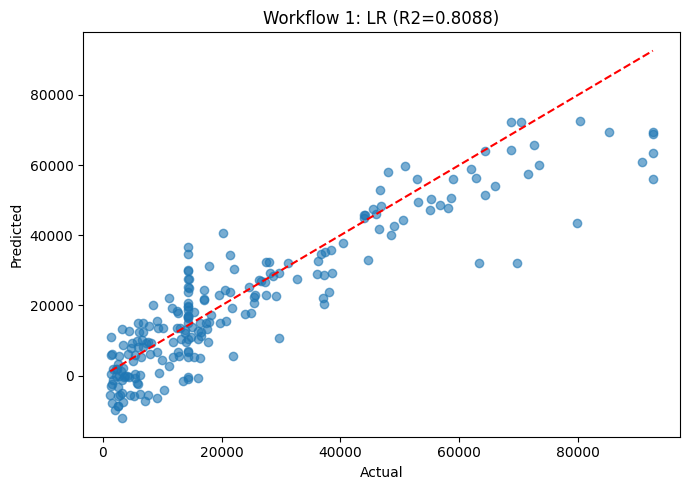

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_test_w1, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title(f'Workflow 1: LR (R2={w1_results["R2"]:.4f})')
plt.tight_layout()
plt.show()

---
# Workflow 2: Correlation + Lasso Selection + Random Forest

## Feature Filtering

### Correlation Filter (same as W1)

In [9]:
w2_corr_features = w1_corr_features.copy()
print(f"After Correlation Filter: {len(w2_corr_features)} features")

After Correlation Filter: 50 features


### Lasso Feature Selection

In [10]:
# Prepare data
X_train_corr2 = train_df[w2_corr_features].values
scaler2 = StandardScaler()
X_train_corr2_scaled = scaler2.fit_transform(X_train_corr2)

# Lasso for feature selection
lasso = Lasso(alpha=100, max_iter=10000)
lasso.fit(X_train_corr2_scaled, y_train)

# Get non-zero features
lasso_idx = np.where(lasso.coef_ != 0)[0]
w2_lasso_features = [w2_corr_features[i] for i in lasso_idx]

print(f"After Lasso Selection: {len(w2_lasso_features)} features")
for i, f in enumerate(w2_lasso_features, 1):
    print(f"  {i}. {f[:50]}")

After Lasso Selection: 38 features
  1. Agriculture, forestry, and fishing, value added (%
  2. Cereal yield (kg per hectare)
  3. Fertilizer consumption (kilograms per hectare of a
  4. Rural population (% of total population)
  5. Access to electricity (% of population)
  6. Mortality rate, under-5 (per 1,000 live births)
  7. Population in urban agglomerations of more than 1 
  8. Renewable energy consumption (% of total final ene
  9. Urban population (% of total population)
  10. Exports of goods and services (% of GDP)
  11. Gross savings (% of GDP)
  12. Medium and high-tech manufacturing value added (% 
  13. Price level ratio of PPP conversion factor (GDP) t
  14. Population ages 0-14 (% of total population)
  15. Population ages 15-64 (% of total population)
  16. School enrollment, preprimary (% gross)
  17. School enrollment, secondary (% gross)
  18. School enrollment, tertiary (% gross)
  19. PM2.5 air pollution, mean annual exposure (microgr
  20. Fixed broadband subscri

## Modeling

### Random Forest

In [11]:
X_train_w2 = train_df[w2_lasso_features].values
X_test_w2 = test_df[w2_lasso_features].values

scaler_w2 = StandardScaler()
X_train_w2_scaled = scaler_w2.fit_transform(X_train_w2)
X_test_w2_scaled = scaler_w2.transform(X_test_w2)

rf = RandomForestRegressor(n_estimators=100, random_state=23)
rf.fit(X_train_w2_scaled, y_train)

y_pred_train_w2 = rf.predict(X_train_w2_scaled)
y_pred_test_w2 = rf.predict(X_test_w2_scaled)


## Evaluation

In [12]:
w2_results = {
    'R2': r2_score(y_test, y_pred_test_w2),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_w2)),
    'MAE': mean_absolute_error(y_test, y_pred_test_w2)
}

w2_results

{'R2': 0.9331810260504957,
 'RMSE': np.float64(5800.716678798999),
 'MAE': 3404.169879629631}

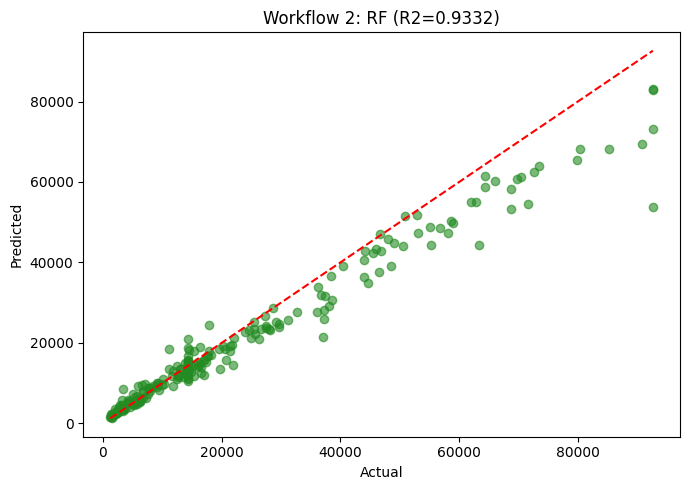

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_test_w2, alpha=0.6, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title(f'Workflow 2: RF (R2={w2_results["R2"]:.4f})')
plt.tight_layout()
plt.show()

---
# Summarize

In [14]:

comparison = pd.DataFrame([
    {'Workflow': 'W1: Corr→RFE→LR', 'Final Features': len(w1_rfe_features), **w1_results},
    {'Workflow': 'W2: Corr→Lasso→RF', 'Final Features': len(w2_lasso_features), **w2_results}
])



# Improvement
r2_imp = (w2_results['R2'] - w1_results['R2']) / abs(w1_results['R2']) * 100 
rmse_imp = (w1_results['RMSE'] - w2_results['RMSE']) / w1_results['RMSE'] * 100
mmse_imp = (w1_results['MAE'] - w2_results['MAE']) / w1_results['MAE'] * 100

print(f"Improvement (W2 vs W1):")
print(f"R2: {r2_imp:+.1f}%")
print(f"RMSE: {rmse_imp:+.1f}%")
print(f"MAE: {mmse_imp:+.1f}%")
comparison

Improvement (W2 vs W1):
R2: +15.4%
RMSE: +40.9%
MAE: +52.8%


,Workflow,Final Features,R2,RMSE,MAE
0,W1: Corr→RFE→LR,40,0.808836,9811.496033,7209.769981
1,W2: Corr→Lasso→RF,38,0.933181,5800.716679,3404.169880
